In [1]:
%matplotlib inline

In [2]:
import fsps

LSST_BANDS = fsps.filters.find_filter('lsst')
zobs_ray = np.linspace(0.25, 4, 25)
dt_mags = np.dtype([('u', 'f4'), ('g', 'f4'), ('r', 'f4'), ('i', 'f4'), ('z', 'f4'), ('y', 'f4')])
dt_ssp = np.dtype([('wave', 'f4'), ('flux', 'f4')])

magpat = "/Users/aphearin/work/repositories/python/dsps/dsps/data/fsps_lsst_mags_zobs_imet_{0}_iage_{1}"
ssppat = "/Users/aphearin/work/repositories/python/dsps/dsps/data/fsps_ssp_imet_{0}_iage_{1}"

np.save("/Users/aphearin/work/repositories/python/dsps/dsps/data/fsps_lsst_mags_zobs.npy", zobs_ray)

In [3]:
imet, iage = 2, 90
sp = fsps.StellarPopulation(zcontinuous=0, zmet=imet, add_neb_emission=1)
mags = np.array([sp.get_mags(bands=LSST_BANDS, redshift=z) for z in zobs_ray])[:, iage, :]
ssp_wave, ssp_fluxes = sp.get_spectrum()
ssp_flux = ssp_fluxes[iage, :]
print(mags.shape)

arr = np.zeros(zobs_ray.size, dtype=dt_mags)
for iband, band in enumerate(dt_mags.names):
    arr[band] = mags[:, iband]
np.save(magpat.format(imet, iage), arr)

arr = np.zeros(ssp_wave.size, dtype=dt_ssp)
arr['wave'] = ssp_wave
arr['flux'] = ssp_flux
np.save(ssppat.format(imet, iage), arr)


(25, 6)


In [4]:
imet, iage = 20, 5
sp = fsps.StellarPopulation(zcontinuous=0, zmet=imet, add_neb_emission=1)
mags = np.array([sp.get_mags(bands=LSST_BANDS, redshift=z) for z in zobs_ray])[:, iage, :]
ssp_wave, ssp_fluxes = sp.get_spectrum()
ssp_flux = ssp_fluxes[iage, :]
print(mags.shape)

arr = np.zeros(zobs_ray.size, dtype=dt_mags)
for iband, band in enumerate(dt_mags.names):
    arr[band] = mags[:, iband]
np.save(magpat.format(imet, iage), arr)

arr = np.zeros(ssp_wave.size, dtype=dt_ssp)
arr['wave'] = ssp_wave
arr['flux'] = ssp_flux
np.save(ssppat.format(imet, iage), arr)


(25, 6)


In [5]:
from dsps.photometry_kernels import _calc_obs_mag_no_dimming, _calc_rest_mag, _calc_obs_mag
from dsps.flat_wcdm import FSPS_COSMO

_a = (*[None] * 4, 0, *[None] * 5)
_calc_obs_mag_vmap_z = jjit(jvmap(_calc_obs_mag, in_axes=_a))


In [6]:
band_wave, band_trans = fsps.filters.get_filter('lsst_u').transmission

In [7]:
args = (ssp_wave, ssp_flux, band_wave, band_trans, zobs_ray, *FSPS_COSMO)
pred_mags = _calc_obs_mag_vmap_z(*args)
print(pred_mags.shape)

(25,)


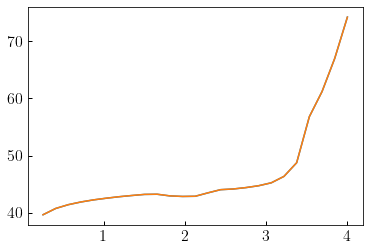

In [8]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(zobs_ray, mags[:, 0])
__=ax.plot(zobs_ray, pred_mags)


In [9]:
np.allclose(mags[:, 0], pred_mags, atol=0.1)

True

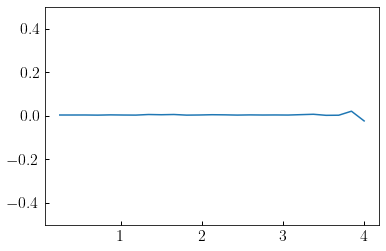

In [10]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(-0.5, 0.5)
__=ax.plot(zobs_ray, pred_mags-mags[:, 0])